In [275]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports and Data

Here we will import the standard data science tools and upload our datasets.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# used for UI customization
from IPython.display import Javascript

In [0]:
counties = pd.read_csv('/content/drive/My Drive/DS100 COVID/covid19/abridged_couties.csv')
states = pd.read_csv('/content/drive/My Drive/DS100 COVID/covid19/4.18states.csv')
deaths = pd.read_csv('/content/drive/My Drive/DS100 COVID/covid19/time_series_covid19_deaths_US.csv')
cases = pd.read_csv('/content/drive/My Drive/DS100 COVID/covid19/time_series_covid19_confirmed_US.csv')

# **EDA**

We knew that we wanted to explore how the different characteristics about a county  (that we have access to) affected the relative toll that the disease took on that county. 

Therefore we will primarily be looking at the ***cases***, ***deaths***, and ***counties*** datasets. Lets take a look at them.

In [278]:
cases.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3,3,5,12,14,15,27,29,32,37,45,51,55,56,58,69,77,82,84,93,112,113,121,121,128,130,133,133,133,133,135,135,136,136
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,6,6,8,8,8,8,8,11,11,11,11,11,11,11,13,13,13,14
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,5,5,5,14,21,23,31,39,51,64,79,100,127,174,239,286,316,316,452,475,513,573,620,683,725,788,897,903,923,974,1043,1068,1118
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,3,3,6,6,7,17,17,17,19,22,23,30,30,30,30,37,40,42,43,43,45,45,50,51,51,51,51,51,51,51,53
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,6,6,6,6,6,7,8,10,12,12,12,12,12,12,15,17,19,19,19,23,24,26,26,25
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,1,1,2,2,2,3,4,4,5,5,10,15,18,19,20,24,28,29,29,38,42,44,56,59,66,71,72,87,91,101,103,109
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,2,3,3,4,9,9,10,10,11,12,14,15,18
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,3,3,4,4,4,5,7,8,9,9,11,13,16,17,17,18,22,24,26
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,4,5,5,5,5,5,6,9,10,10,10,10,10,11,12,12,13,14,16,17,18,20,20


In [279]:
deaths.head(10)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,Population,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.271000,-170.132000,"American Samoa, US",55641,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.444300,144.793700,"Guam, US",164229,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,3,3,4,4,4,4,4,4,4,4,5,5,5,5,5,5,5,5
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.097900,145.673900,"Northern Mariana Islands, US",55144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.220800,-66.590100,"Puerto Rico, US",2933408,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,1,2,2,2,2,3,3,3,6,8,11,12,15,18,20,21,23,24,33,39,42,44,45,45,51,56,58,60
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.335800,-64.896300,"Virgin Islands, US",107268,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,2,3
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,"Autauga, Alabama, US",55869,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,2,2
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,"Baldwin, Alabama, US",223234,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,2
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,"Barbour, Alabama, US",24686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,"Bibb, Alabama, US",22394,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,"Blount, Alabama, US",57826,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [280]:
counties.head(5)

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,1594.0,1736.0,3978.0,4265.0,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,1162.0,646.0,2115.0,1513.0,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1013.0,633.0,1895.0,1487.0,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944

The granularity of the ***cases*** and ***deaths*** is a little tricky to pinpoint, as the first few entries in each represent US territories. After looking at a few more rows, though, it becomes clear that generally for this dataset, a row represents a US county.

In ***counties***, each row clearly represents a county. 

The Admin2 and Province_State together serve as a primary key for both cases and deaths, which we can use to join with counties. 

As a sanity check we can check out if each set contains the same states.  

In [0]:
c_states = cases['Province_State'].unique()
# c_states

In [0]:
d_states = deaths['Province_State'].unique()
# d_states

In [0]:
a_states = counties['State'].unique()
# a_states

In [284]:
print('There are {} state values in the cases dataset'.format(len(c_states)))
print('There are {} state values in the deaths dataset'.format(len(d_states)))
print('There are {} state values in the counties dataset'.format(len(a_states)))

There are 58 state values in the cases dataset
There are 58 state values in the deaths dataset
There are 50 state values in the counties dataset


It looks like there are extra values in the column representing state names in the ***cases*** and ***deaths*** datasets that we will need to clean later. 

We can also see that there is a discrepancy between the number of counties in each state across our datasets. 
As an example, we'll look at Texas.

In [285]:
len(cases[cases['Province_State'] == 'Texas'])

256

In [286]:
len(deaths[deaths['Province_State'] == 'Texas'])

256

In [287]:
len(counties[counties['State'] == 'Texas'])

254



---



At this point in the process, we are very interested to see if were are able to model the number of cases in the county on the final day of reporting with our county information. 

To better understand this reponse variable, we've plotted it below.

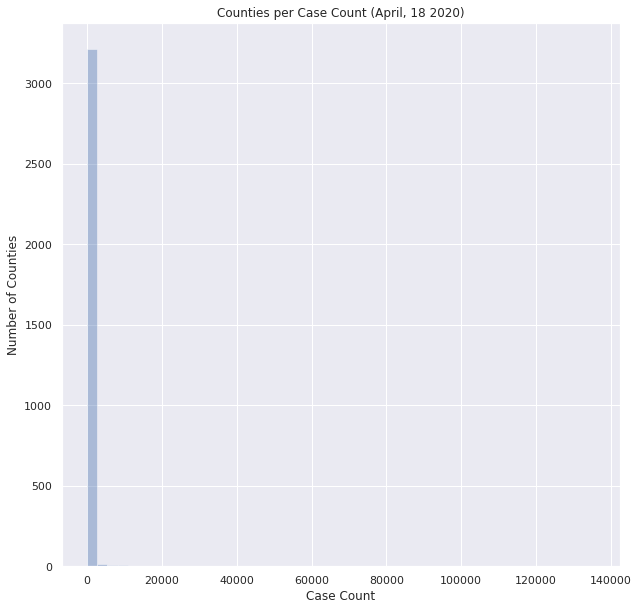

In [288]:
ax = sns.distplot(cases['4/18/20'],kde = False)
ax.set(xlabel='Case Count', ylabel='Number of Counties', title='Counties per Case Count (April, 18 2020)')
plt.show();

This weird and rather useless histogram suggests that we have at least one county with an extremely large number of cases. Lets investigate our data to see who the culprit is.  

In [0]:
# cases.iloc[pd.Series.argmax(cases[['4/18/20']])]

In [290]:
cases[['4/18/20']].max()[0]

135572

In [291]:
cases[cases['4/18/20'] == 135572]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572


As [reported](https://www.wsj.com/articles/new-york-citys-coronavirus-deaths-match-demographics-in-other-hot-spots-11587214800) in the news, it looks like New York City is an extreme outlier with more than 135,000 cases (on April 18, 2020). 
We can try and limit our range of cases to get a better understanding of the number of counties afflicted by amounts of cases that are not astronomical. 

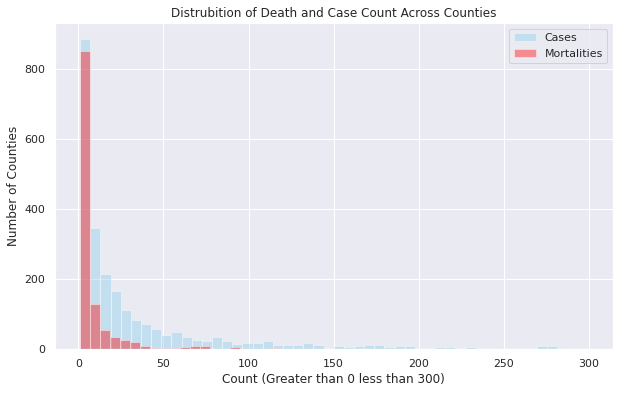

In [292]:
plt.figure(figsize=(10,6))
ax = sns.distplot(cases[(cases['4/18/20'] < 300) & (cases['4/18/20'] > 0)]['4/18/20'], color="skyblue", kde = False, label="Cases")
ax = sns.distplot(deaths[(deaths['4/18/20'] < 300) & (deaths['4/18/20'] > 0)]['4/18/20'], color="red", kde = False, label="Mortalities")
ax.set(xlabel='Count (Greater than 0 less than 300)', ylabel='Number of Counties', title='Distrubition of Death and Case Count Across Counties')
ax.legend();


Even when only looking at counties with less than 300 counties, the distribution is still strongly pressed against 0.
Many counties still only had a handful of cases on April 18, 2020. 
This strange distribution of our response variable suggested that perhaps we would be better served modeling not the number of confirmed cases by the last day of reporting, but the mortality rate. 

---



We can also look at how continuous variables in ***counties*** are related to each other. Here we will look at the relationship between respiratory mortalities and other variables in our dataset. 

In [0]:
def feature_plot(x_var, y_var, title, xlog=0, data=counties):
  """
  Inputs:
  - x_var: county feature that is likely correlated with a counties resperatory mortality rate 
  - y_var: another county fearure (set to reperatory mortality rate)
  - xlog: 0 normal scale, 1 for log scale
  - data: set to the counties dataset
  
  Output:
  - a scatter plot of the two variables
  """
  plt.figure(figsize=(10,6))
  ax = sns.regplot(x=x_var, y=y_var, 
                   data=data, 
                   ci=None,
                   scatter_kws={'alpha':0.30},
                   line_kws={"color":"r","alpha":0.7})
  ax.set_title(title)
  ax.set_xlim(None, None)
  ax.set_ylim(None, None)

  if xlog != 0:
    ax.set_xscale('log')
  plt.show();

Lets look at the scatterplot between **Smokers_Percentage** and mortality rates: the estimated percentage of adult smokers in county (2017)

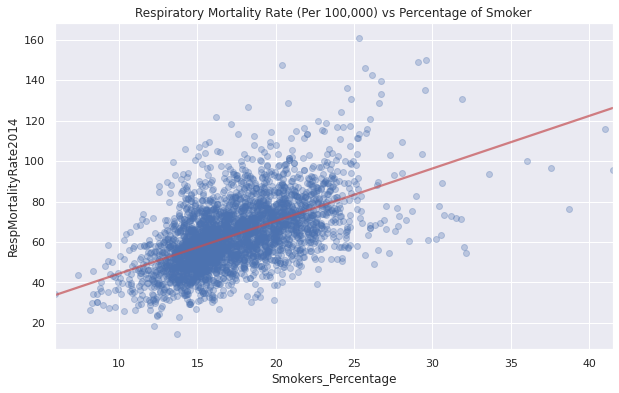

In [294]:
feature_plot(x_var='Smokers_Percentage', y_var='RespMortalityRate2014', title='Respiratory Mortality Rate (Per 100,000) vs Percentage of Smoker')

#TODO: TITLE Plot 
# or maybe not... look to see if they titled feature plots in past proj/lec/hw


Lets look at **SVIPercentile**: the county's overall percentile ranking indicating the [CDC's Social Vulnerability Index (SVI)](https://svi.cdc.gov); a higher ranking indicates worse social vulnerability, a measure of '...the resilience of communities when confronted by external stresses on human health...'.

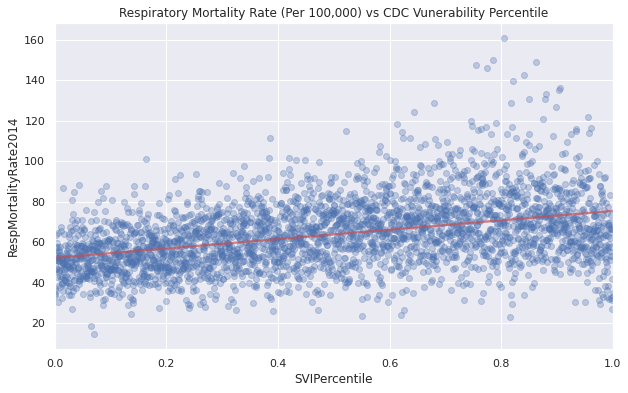

In [295]:
feature_plot(x_var='SVIPercentile', y_var='RespMortalityRate2014', title='Respiratory Mortality Rate (Per 100,000) vs CDC Vunerability Percentile')

*As* we can see by checking out their scatterplots lines of best fit, some variables in ***counties*** are well correlated with respiratory mortalities. We will reuse out *feature_plot* function when selecting features in our regression on Covid cases.

# **Transformation and Cleaning**

### 1) Merging Data and Merging Prep

As a first step in our cleaning pipeline, lets merge our dataframes of interest ***counties***, ***cases***, and ***deaths***. But before we start, lets drop some of our unnecessary columns to make future cleaning more manageble. 

We know that ***cases*** and ***deaths*** have many of the same columns. We also will only be looking at aggregate cases and deaths so we will only take a look at the most recent data (4/18/2020).


In [296]:
deaths1 = deaths[['Admin2', 'Province_State', '4/18/20']]
deaths1 = deaths1.rename(columns={'4/18/20':'agg_deaths'})
deaths1.head()

,Admin2,Province_State,agg_deaths
0,NaN,American Samoa,0
1,NaN,Guam,5
2,NaN,Northern Mariana Islands,2
3,NaN,Puerto Rico,60
4,NaN,Virgin Islands,3


In [297]:
cases1 = cases[['Admin2', 'Province_State', '4/18/20']]
cases1 = cases1.rename(columns={'4/18/20':'agg_cases'})
cases1.head()

,Admin2,Province_State,agg_cases
0,NaN,American Samoa,0
1,NaN,Guam,136
2,NaN,Northern Mariana Islands,14
3,NaN,Puerto Rico,1118
4,NaN,Virgin Islands,53


Now that we have trimmed our ***cases*** and ***deaths*** dataframes to their most essential components for merging, we can merge these tables with ***counties***.

In [0]:
cases_deaths = pd.merge(cases1, deaths1, on=['Admin2', 'Province_State'])

In [299]:
data = pd.merge(counties, cases_deaths, 
                left_on=['CountyName', 'State'], 
                right_on=['Admin2', 'Province_State'])
data.head()

,countyFIPS,STATEFP,COUNTYFP,CountyName,StateName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,CensusDivisionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopTotalMale2017,PopTotalFemale2017,FracMale2017,PopulationEstimate65+2017,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",3-YrDiabetes2015-17,DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,...,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge<1Year2015-17,3-YrMortalityAge1-4Years2015-17,3-YrMortalityAge5-14Years2015-17,3-YrMortalityAge15-24Years2015-17,3-YrMortalityAge25-34Years2015-17,3-YrMortalityAge35-44Years2015-17,3-YrMortalityAge45-54Years2015-17,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,mortality2015-17Estimated,stay at home,>50 gatherings,>500 gatherings,public schools,restaurant dine-in,entertainment/gym,federal guidelines,foreign travel ban,SVIPercentile,HPSAShortage,HPSAServedPop,HPSAUnderservedPop,Admin2,Province_State,agg_cases,agg_deaths
0,01001,1.0,1.0,Autauga,AL,Alabama,32.540091,-86.645649,32.500389,-86.494165,South,East South Central,2.0,55601.0,27007.0,28497.0,0.486578,8392.0,91.8,54571.0,37.0,11439.0,8046.0,16.0,9.9,204.5,56.1,18.081557,81.79,324.0,50.0,0.0,1.0,6.0,0.326656,1866.0,1713.0,2001.0,1990.0,2171.0,...,4040.0,4165.0,1524.0,1559.0,1279.0,1498.0,1821.0,2192.0,841.0,1141.0,159.0,392.0,NaN,NaN,NaN,NaN,10.0,20.0,44.0,73.0,112.0,143.0,109.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.4354,NaN,NaN,NaN,Autauga,Alabama,25,2
1,01003,1.0,3.0,Baldwin,AL,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,East South Central,3.0,218022.0,103225.0,109403.0,0.485472,42413.0,114.7,182265.0,41.1,54145.0,41590.0,33.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,...,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,13.0,NaN,NaN,23.0,30.0,52.0,125.0,262.0,434.0,546.0,597.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.2162,NaN,NaN,NaN,Baldwin,Alabama,109,2
2,01005,1.0,5.0,Barbour,AL,Alabama,31.874030,-85.397327,31.844036,-85.310038,South,East South Central,6.0,24881.0,13335.0,11935.0,0.527701,4757.0,31.0,27457.0,39.0,6681.0,4706.0,NaN,15.7,220.4,49.0,21.999985,69.82,181.0,12.0,0.0,1.0,5.0,0.893106,847.0,855.0,826.0,816.0,820.0,...,2164.0,1854.0,910.0,907.0,859.0,940.0,1067.0,1171.0,498.0,730.0,129.0,314.0,NaN,NaN,NaN,NaN,NaN,NaN,21.0,44.0,65.0,72.0,68.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.9959,6.08,5400.0,18241.0,Barbour,Alabama,18,0
3,01007,1.0,7.0,Bibb,AL,Alabama,32.999024,-87.125260,33.030921,-87.127659,South,East South Central,1.0,22400.0,12138.0,10530.0,0.535469,3632.0,36.8,22915.0,37.8,5128.0,3389.0,NaN,13.3,225.5,57.2,19.114200,84.49,145.0,16.0,0.0,1.0,0.0,0.278124,712.0,666.0,759.0,646.0,771.0,...,1883.0,1503.0,734.0,667.0,684.0,650.0,803.0,920.0,370.0,534.0,73.0,206.0,NaN,NaN,NaN,NaN,NaN,NaN,24.0,37.0,62.0,56.0,45.0,NaN,737519.0,737504.0,737497.0,737500.0,737503.0,737512.0,737500.0,737495.0,0.6003,2.75,14980.0,6120.0,Bibb,Alabama,26,0
4,01009,1.0,9.0,Blount,AL,Alabama,33.990440,-86.562711,33.955243,-86.591491,South,East South Central,1.0,57840.0,28607.0,29406.0,0.493114,10351.0,88.9,57322.0,39.0,13175.0,9542.0,NaN,14.9,224.8,52.8,19.208672,87.05,103.0,18.0,1.0,1.0,6.0,0.094317,1805.0,1811.0,1936.0,1944.0,2113.0,...,4068.0,4017.0,1810.0,1884.0,1700.0,1882.0

In [300]:
data.shape

(3024, 91)

A point of concern here is that through this process of merging, we are now left with fewer rows of information then we originally did in the time series datasets. This was to be expected, as we understood that these datasets included counts for non-county locations, whereas our counties dataset obviously only had information on counties. Considering that our dataframe is still sufficiently large, with 3024 unique counties, we are happy to continue and should still be able to learn from this set. 


## 2) Dropping Duplicates and Linear Combinations

Now that we have merged our important datasets, lets identify duplicate or otherwise redundant (simple scalar of another column) features and drop them from our dataframe. Note that we are doing this simply by inspection and by applying domain knowledge.

In [0]:
redundant = ['countyFIPS', 'STATEFP', 'COUNTYFP', 'Admin2', 
             'Province_State', 'StateName', 'CensusDivisionName']
scalars = [ 'PopTotalFemale2017', 'FracMale2017', 
             'PopulationEstimate65+2017', 'PopTotalMale2017']
             
data = data.drop(redundant + scalars, axis = 1) 

## 3) Restricting the Data

Having dropped the unnecessary columns from our dataset, we are also interested in restricting our data set to the particularities of our question.  


First off, we want to remove all counties from our dataset that have zero cases. Because we are interested in predicting the Covid moratlity rate for counties, we are unconcerned with counties that have no reported cases of Covid.

In [0]:
data = data.loc[~((data['agg_cases'] == 0)),:]

We are also intrerested in reducing our counties with Covid cases to those counties with 100 or more confirmed cases. We do this because variation in mortality rate for smaller counties is mostly due to the small sample size. 

In [303]:
data = data[data['agg_cases'] > 100]
data.shape

(484, 80)

As we can see, this greatly reduces our number of observations. 

## 4) Cleaning NaNs and Anomolies


Now that we have a full dataset containing all of the features we can use for future feature engineering and modelling, lets manage NaN values and other anomolies in our ***data*** data.

In [304]:
# changes the output display height 
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'''))
pd.set_option('display.max_rows', None)

nans = {'columns':list(data.columns), "nans":list(data.isnull().sum(axis = 0))}
pd.DataFrame(nans)

<IPython.core.display.Javascript object>

,columns,nans
0,CountyName,0
1,State,0
2,lat,0
3,lon,0
4,POP_LATITUDE,0
5,POP_LONGITUDE,0
6,CensusRegionName,0
7,Rural-UrbanContinuumCode2013,0
8,PopulationEstimate2018,0
9,PopulationDensityperSqMile2010,0


Looking at our data, there seems to be many NaN values for data that is trying to capture mortality rates for different age groups. Our first step here will be to drop these columns afflicted with a high percentage of NaN values. 


By dropping counties with NaN values for these features, we would loose too much valuable information for our model. Instead we have opted to drop these high-NaN features. 

In [0]:
first_drop = ['3-YrMortalityAge<1Year2015-17', '3-YrMortalityAge1-4Years2015-17', 
             '3-YrMortalityAge5-14Years2015-17' , '3-YrMortalityAge15-24Years2015-17',
             '3-YrMortalityAge25-34Years2015-17', '3-YrMortalityAge35-44Years2015-17',
             '3-YrMortalityAge45-54Years2015-17', 'mortality2015-17Estimated']
data = data.drop(first_drop, axis = 1) 

Lets also drop *3-YrDiabetes2015-17*, *HPSAShortage*, *HPSAServedPop*, and *HPSAUnderservedPop* for the same reason.



In [0]:
second_drop = ['3-YrDiabetes2015-17', 'HPSAShortage', 'HPSAServedPop', 'HPSAUnderservedPop']
data = data.drop(second_drop, axis = 1) 

In [307]:
# changes the output display height 
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 400})'''))

data.isnull().sum(axis = 0)

<IPython.core.display.Javascript object>

CountyName                            0
State                                 0
lat                                   0
lon                                   0
POP_LATITUDE                          0
POP_LONGITUDE                         0
CensusRegionName                      0
Rural-UrbanContinuumCode2013          0
PopulationEstimate2018                0
PopulationDensityperSqMile2010        0
CensusPopulation2010                  0
MedianAge2010                         0
#EligibleforMedicare2018              0
MedicareEnrollment,AgedTot2017        0
DiabetesPercentage                    0
HeartDiseaseMortality                 0
StrokeMortality                       0
Smokers_Percentage                    0
RespMortalityRate2014                 0
#FTEHospitalTotal2017                 0
TotalM.D.'s,TotNon-FedandFed2017      0
#HospParticipatinginNetwork2017       0
#Hospitals                            0
#ICU_beds                             0
dem_to_rep_ratio                      0


For the remaining columns with NaN values, we will assume that NaN means that those particular counties never put into place formal restrictions. With that being said we will drop the columns in this category with no NaN values (an all 1's column will provide no usefull information for our model). 


In [0]:
third_drop = ['public schools', 'restaurant dine-in', 'federal guidelines', 'foreign travel ban']
data = data.drop(third_drop, axis = 1) 

# **Modeling and Feature Engineering**

We just did a lot of cleaning so let's get a sense of the contents of ***data***.

In [309]:
data.head()

,CountyName,State,lat,lon,POP_LATITUDE,POP_LONGITUDE,CensusRegionName,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,PopFmle45-542010,PopMale55-592010,PopFmle55-592010,PopMale60-642010,PopFmle60-642010,PopMale65-742010,PopFmle65-742010,PopMale75-842010,PopFmle75-842010,PopMale>842010,PopFmle>842010,3-YrMortalityAge55-64Years2015-17,3-YrMortalityAge65-74Years2015-17,3-YrMortalityAge75-84Years2015-17,3-YrMortalityAge85+Years2015-17,stay at home,>50 gatherings,>500 gatherings,entertainment/gym,SVIPercentile,agg_cases,agg_deaths
1,Baldwin,Alabama,30.738314,-87.726272,30.548923,-87.762381,South,3.0,218022.0,114.7,182265.0,41.1,54145.0,41590.0,8.5,183.2,41.9,17.489033,54.28,2101.0,536.0,0.0,3.0,51.0,0.253255,5614.0,5544.0,5832.0,5767.0,6076.0,5850.0,5930.0,5670.0,4793.0,4656.0,5183.0,5064.0,5317.0,5392.0,11620.0,11933.0,13047.0,13874.0,5943.0,6580.0,5728.0,6284.0,8558.0,9245.0,4379.0,5153.0,1176.0,2057.0,262.0,434.0,546.0,597.0,737519.0,737504.0,737497.0,737512.0,0.2162,109,2
8,Chambers,Alabama,32.916331,-85.394853,32.860439,-85.266474,South,6.0,33615.0,57.4,34215.0,41.5,9276.0,6342.0,17.5,196.7,45.2,19.392927,84.00,0.0,28.0,0.0,0.0,0.0,0.737473,981.0,972.0,1081.0,964.0,1134.0,1103.0,1168.0,1130.0,1003.0,922.0,902.0,985.0,922.0,992.0,2189.0,2243.0,2430.0,2619.0,1165.0,1302.0,1077.0,1225.0,1456.0,1652.0,666.0,1161.0,189.0,582.0,72.0,97.0,105.0,114.0,737519.0,737504.0,737497.0,737512.0,0.7382,240,11
35,Jefferson,Alabama,33.563058,-86.890254,33.518601,-86.814688,South,1.0,659300.0,592.5,658466.0,37.1,136483.0,100601.0,11.7,190.9,59.6,17.622045,59.24,24703.0,4626.0,3.0,8.0,471.0,1.164023,22313.0,21584.0,21211.0,20691.0,21719.0,20654.0,22568.0,22094.0,22298.0,24107.0,23224.0,25309.0,21452.0,23312.0,40290.0,43303.0,44905.0,50328.0,20837.0,23865.0,16769.0,19190.0,19317.0,24956.0,11131.0,18496.0,3779.0,8764.0,1107.0,1346.0,1538.0,1998.0,737510.0,737504.0,737497.0,737512.0,0.6621,671,25
39,Lee,Alabama,32.609918,-85.355263,32.588092,-85.345833,South,3.0,163941.0,230.9,140247.0,29.5,24613.0,17381.0,9.5,180.2,45.9,17.560140,74.45,2833.0,249.0,0.0,1.0,28.0,0.613282,4456.0,4231.0,4394.0,4061.0,4495.0,4493.0,6581.0,6604.0,10868.0,10227.0,5430.0,5245.0,4229.0,4443.0,8372.0,8889.0,8389.0,8757.0,3348.0,3776.0,3015.0,3228.0,3514.0,4013.0,1665.0,2227.0,370.0,927.0,148.0,226.0,241.0,250.0,737519.0,737504.0,737497.0,737512.0,0.6602,305,14
43,Madison,Alabama,34.765188,-86.543127,34.746392,-86.613232,South,2.0,366519.0,417.7,334811.0,37.3,67210.0,52375.0,12.4,197.2,42.4,16.820173,61.87,8900.0,1188.0,1.0,2.0,100.0,0.701765,10595.0,10274.0,10942.0,10343.0,11675.0,11159.0,12829.0,11948.0,12417.0,11904.0,11826.0,11420.0,10245.0,10467.0,21441.0,22916.0,26545.0,27271.0,10015.0,10561.0,8220.0,8925.0,10499.0,12652.0,5625.0,7659.0,1446.0,2992.0,435.0,596.0,809.0,829.0,737519.0,737504.0,737497.0,737512.0,0.3076,197,4


## 1) Feature Engineering

Before we start modeling, we are interested in feature engineering our data in four different ways. 


1.   convert columns *stay at home* to *entertainment/gym*, "**1**" for counties that implemented a restriction and "**0**" for counties that didn't

2. **one-hot-encode** the *CensusRegionName* and *State* columns

3. generate the mortality rate statistic

4. **normalize** our features to get interpretable weights


In [0]:
def feature_eng(data, features, ohes):
  """
  Inputs:
  - data: dataset to be feature engineered 
  - features: list of features to be converted to 1 if value is not NaN and 0 otherwise
  - ohe: features to be one-hot-encoded
  
  Output:
  - a feature engineered dataframe
  """
  data_copy = data.copy()

  # converts features
  for feat in features:
    data_copy[feat] = data_copy[feat].fillna(0)
    data_copy[feat][data_copy[feat] != 0] = 1

  # ohe features
  for ohe in ohes:
    ohe_matrix = pd.get_dummies(data_copy[ohe], prefix=ohe, drop_first=True)
    data_copy = pd.concat([data_copy, ohe_matrix], axis=1, join='inner').drop(columns=[ohe])

  # adds mortality rate stat
  data_copy['mortality_rate (%)'] = np.round((data_copy['agg_deaths']/data_copy['agg_cases'])*100, 2)
  data_copy = data_copy.drop(['agg_deaths'], axis = 1) 

  # normalizes non-catagorical features
  cols = data_copy.columns
  condition = (cols != 'mortality_rate (%)') & (cols != 'CountyName')
  data_copy.loc[:, condition] = (data_copy.loc[:, condition] - data_copy.loc[:, condition].mean()) / data_copy.loc[:, condition].std()
  
  return data_copy

In [311]:
convert_list = ['stay at home', '>50 gatherings',
                '>500 gatherings', 'entertainment/gym']

feng_data = feature_eng(data, convert_list, ['CensusRegionName', 'State'])
feng_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


,CountyName,lat,lon,POP_LATITUDE,POP_LONGITUDE,Rural-UrbanContinuumCode2013,PopulationEstimate2018,PopulationDensityperSqMile2010,CensusPopulation2010,MedianAge2010,#EligibleforMedicare2018,"MedicareEnrollment,AgedTot2017",DiabetesPercentage,HeartDiseaseMortality,StrokeMortality,Smokers_Percentage,RespMortalityRate2014,#FTEHospitalTotal2017,"TotalM.D.'s,TotNon-FedandFed2017",#HospParticipatinginNetwork2017,#Hospitals,#ICU_beds,dem_to_rep_ratio,PopMale<52010,PopFmle<52010,PopMale5-92010,PopFmle5-92010,PopMale10-142010,PopFmle10-142010,PopMale15-192010,PopFmle15-192010,PopMale20-242010,PopFmle20-242010,PopMale25-292010,PopFmle25-292010,PopMale30-342010,PopFmle30-342010,PopMale35-442010,PopFmle35-442010,PopMale45-542010,...,State_Georgia,State_Idaho,State_Illinois,State_Indiana,State_Iowa,State_Kansas,State_Kentucky,State_Louisiana,State_Maine,State_Maryland,State_Massachusetts,State_Michigan,State_Minnesota,State_Mississippi,State_Missouri,State_Montana,State_Nebraska,State_Nevada,State_New Hampshire,State_New Jersey,State_New Mexico,State_New York,State_North Carolina,State_North Dakota,State_Ohio,State_Oklahoma,State_Oregon,State_Pennsylvania,State_Rhode Island,State_South Carolina,State_South Dakota,State_Tennessee,State_Texas,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,mortality_rate (%)
1,Baldwin,-1.370649,0.067038,-1.407098,0.065096,0.731710,-0.330568,-0.233170,-0.356663,0.886741,-0.238907,-0.242499,-0.374234,0.405296,0.520261,0.476983,-0.061979,-0.448032,-0.394147,-0.670481,-0.182340,-0.340329,-0.889009,-0.370510,-0.363191,-0.372198,-0.364717,-0.359908,-0.357604,-0.373736,-0.373821,-0.402305,-0.407146,-0.369022,-0.376572,-0.353921,-0.357763,-0.353905,-0.356018,-0.367034,...,-0.287407,-0.091193,-0.145098,-0.190597,-0.137507,-0.102063,-0.102063,-0.21275,-0.064349,-0.165963,-0.159283,-0.190597,-0.091193,-0.145098,-0.064349,-0.045455,-0.064349,-0.064349,-0.064349,-0.21275,-0.091193,-0.22818,-0.190597,-0.045455,-0.207399,-0.102063,-0.091193,-0.233139,-0.091193,-0.172411,-0.045455,-0.145098,-0.22818,-0.111921,-0.045455,-0.129507,-0.165963,-0.064349,-0.111921,1.83
8,Chambers,-0.929020,0.234048,-0.938373,0.243308,3.001887,-0.584668,-0.249694,-0.573712,0.982354,-0.635307,-0.623197,2.864719,0.773854,0.950164,1.062530,2.090147,-0.592621,-0.549978,-0.670481,-0.718286,-0.617790,-0.438199,-0.565191,-0.563566,-0.575776,-0.579183,-0.565145,-0.563587,-0.558258,-0.558710,-0.548299,-0.556589,-0.528382,-0.530409,-0.530022,-0.534946,-0.547969,-0.553952,-0.592694,...,-0.287407,-0.091193,-0.145098,-0.190597,-0.137507,-0.102063,-0.102063,-0.21275,-0.064349,-0.165963,-0.159283,-0.190597,-0.091193,-0.145098,-0.064349,-0.045455,-0.064349,-0.064349,-0.064349,-0.21275,-0.091193,-0.22818,-0.190597,-0.045455,-0.207399,-0.102063,-0.091193,-0.233139,-0.091193,-0.172411,-0.045455,-0.145098,-0.22818,-0.111921,-0.045455,-0.129507,-0.165963,-0.064349,-0.111921,4.58
35,Jefferson,-0.797886,0.126926,-0.804912,0.132763,-0.781741,0.277482,-0.095376,0.341470,-0.069389,0.488516,0.394853,0.777393,0.615511,2.826107,0.517891,0.297191,1.107419,0.860474,0.354297,0.710903,1.944643,-0.041078,0.331191,0.339785,0.286785,0.301674,0.289732,0.284775,0.270969,0.295037,0.272003,0.371326,0.302552,0.386957,0.292582,0.363856,0.236045,0.284767,0.310094,...,-0.287407,-0.091193,-0.145098,-0.190597,-0.137507,-0.102063,-0.102063,-0.21275,-0.064349,-0.165963,-0.159283,-0.190597,-0.091193,-0.145098,-0.064349,-0.045455,-0.064349,-0.064349,-0.064349,-0.21275,-0.091193,-0.22818,-0.190597,-0.045455,-0.207399,-0.102063,-0.091193,-0.233139,-0.091193,-0.172411,-0.045455,-0.145098,-0.22818,-0.111921,-0.045455,-0.129507,-0.165963,-0.064349,-0.111921,3.73
39,Lee,-0.991151,0.236884,-0.993599,0.237641,0.731710,-0.405088,-0.199658,-0.418264,-1.886035,-0.499811,-0.503970,-0.014351,0.323394,1.041356,0.498852,1.398599,-0.397656,-0.482185,-0.670481,-0.539637,-0.465459,-0.553821,-0.419169,-0.420735,-0.433815,-0.440894,-0.425565,-0.416487,-0.348510,-0.335784,

Before beginning modeling, let's get a sense for our newly added mortality rate column.

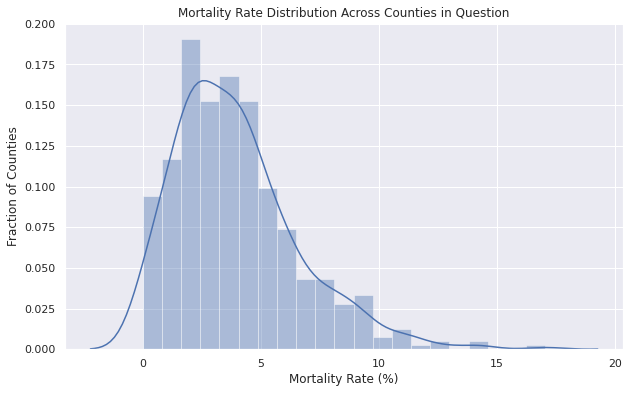

In [312]:
plt.figure(figsize=(10,6))
ax = sns.distplot(feng_data['mortality_rate (%)'])
ax.set(xlabel='Mortality Rate (%)', ylabel='Fraction of Counties', title='Mortality Rate Distribution Across Counties in Question')
plt.show();

T

In [313]:
print("Maximum Mortality Rate: " + str(float(feng_data[['mortality_rate (%)']].max())))
print("Minimum Mortality Rate: " + str(float(feng_data[['mortality_rate (%)']].min())))

Maximum Mortality Rate: 17.05
Minimum Mortality Rate: 0.0


Out of curiosity and eventual anecdotal relevance to the report, let's check out the mortality rates of New York and San Diego, two major counties.

In [314]:
feng_data[feng_data['CountyName'] == 'New York'][['CountyName', 'mortality_rate (%)']]

,CountyName,mortality_rate (%)
1782,New York,9.74


In [315]:
feng_data[feng_data['CountyName'] == 'San Diego'][['CountyName', 'mortality_rate (%)']]

,CountyName,mortality_rate (%)
190,San Diego,3.24


## 2) Modeling

With feature engineering complete we can split our data and assign our output variable to *mortality_rate*.

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(feng_data, test_size=0.25, random_state=83)

In [317]:
Y_train = train['mortality_rate (%)']
Y_test = test['mortality_rate (%)']
type(train.columns[1])

str

Here, we can use the *feature_plot* to cycle through our features and see which ones are correlated with mortality rate. Below we will just display the scatterplot of Mortality Rate vs the normalized percentage of the population with diabetes, but the same logic applies to any of the columns, and we cycled through them to gain insight.


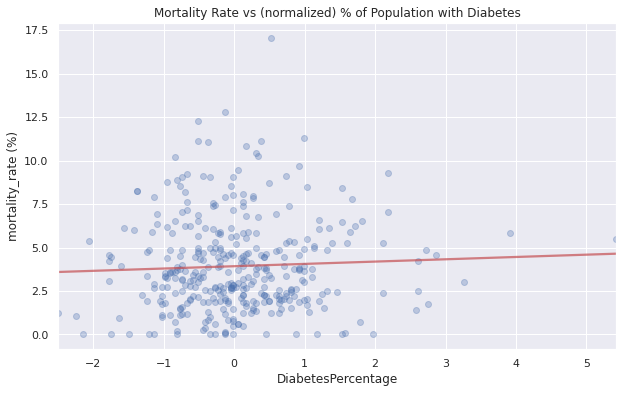

In [318]:
feature_plot(x_var = 'DiabetesPercentage', y_var='mortality_rate (%)', title='Mortality Rate vs (normalized) % of Population with Diabetes', data=train)

After looking through our features, these seem to be the best at explaining variance in mortality rates. We will test this in the subsequent model comparisons.

In [0]:
high_cor_features = ['MedianAge2010', 'DiabetesPercentage', 'HeartDiseaseMortality', 
                     'StrokeMortality', 'Smokers_Percentage', 'RespMortalityRate2014',
                     'dem_to_rep_ratio', 'agg_cases']

### Modeling Functions

Here we will define out **Root Mean Squared Error** and **Cross Validation Error** terms.

In [0]:
from sklearn.model_selection import cross_val_predict

def rmse(y, yhat):
    return np.sqrt(np.mean((y - yhat)**2))

Now lets construct a way to visualize the efficacy of our models using these error terms.

In [0]:
errors = {'CV Error': {}, 'Training Error': {}, 'Test Error': {}}

def compare_models(model_name, cv_score=0, tr_score=0, te_score=0, dict=errors):
  """Produces a bar chart for each model plotting cv error and training error"""
  errors['CV Error'].update({model_name: cv_score}) 
  errors['Training Error'].update({model_name: tr_score})
  errors['Test Error'].update({model_name: te_score})
  ax = pd.DataFrame(errors).plot(kind='bar', figsize=(14,6))
  ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  ax.set_ylabel('RMSE');

Here we will also make a function to find the cv error and training error for a given set of features. 

In [0]:
def regress(data, features, output=Y_train):
  """ Takes in data and feature list and returns the cv and training error"""
  X_train = data[features]

  model = LinearRegression()
  model.fit(X_train, output)

  predictions = model.predict(X_train)

  cv_error = rmse(output, cross_val_predict(model, X_train, output ,cv=10))
  t_error = rmse(output, predictions)

  return cv_error, t_error


### Model 1

For our first model, let's use features relevant to population size and composition.

In [323]:
p_features = ['PopulationEstimate2018', 'PopulationDensityperSqMile2010', 
                  'PopFmle<52010', 'PopMale5-92010', 'PopFmle5-92010', 'PopMale10-142010',
                  'PopFmle10-142010', 'PopMale15-192010', 'PopFmle15-192010',
                  'PopMale20-242010', 'PopFmle20-242010', 'PopMale25-292010',
                  'PopFmle25-292010', 'PopMale30-342010', 'PopFmle30-342010',
                  'PopMale35-442010', 'PopFmle35-442010', 'PopMale45-542010',
                  'PopFmle45-542010', 'PopMale55-592010', 'PopFmle55-592010',
                  'PopMale60-642010', 'PopFmle60-642010', 'PopMale65-742010',
                  'PopFmle65-742010','PopMale75-842010', 'PopFmle75-842010', 
                  'PopMale>842010', 'PopFmle>842010']

pop_cve, pop_te = regress(train, p_features)

print('CV Error (RMSE):', pop_cve)
print('Training Error (RMSE):', pop_te)

CV Error (RMSE): 2.7302334951727345
Training Error (RMSE): 2.5141777804863428


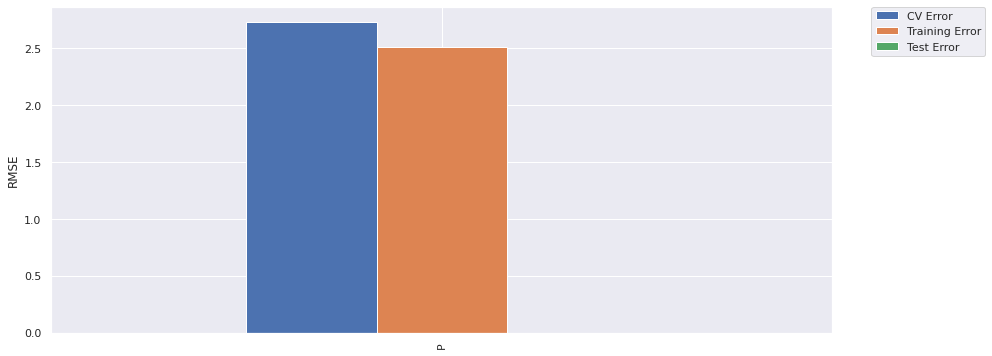

In [324]:
compare_models('P', pop_cve, pop_te)

### Model 2

For our second model, lets add location specific data to our model.

In [325]:
p_l_features = p_features + ['CensusRegionName_Northeast', 'CensusRegionName_South', 'CensusRegionName_West',
                   'State_Arizona', 'State_Arkansas', 'State_California', 'State_Colorado', 
                   'State_Connecticut', 'State_Delaware', 'State_Florida', 'State_Georgia', 
                   'State_Idaho', 'State_Illinois', 'State_Indiana', 'State_Iowa', 'State_Kansas',
                   'State_Kentucky', 'State_Louisiana', 'State_Maine', 'State_Maryland',
                   'State_Massachusetts', 'State_Michigan', 'State_Minnesota', 'State_Mississippi', 
                   'State_Missouri', 'State_Montana', 'State_Nebraska', 'State_Nevada', 
                   'State_New Hampshire', 'State_New Jersey', 'State_New Mexico', 'State_New York',
                   'State_North Carolina', 'State_North Dakota', 'State_Ohio', 'State_Oklahoma', 
                   'State_Oregon', 'State_Pennsylvania', 'State_Rhode Island', 'State_South Carolina',
                   'State_South Dakota', 'State_Tennessee', 'State_Texas', 'State_Utah', 'State_Vermont',
                   'State_Virginia', 'State_Washington', 'State_West Virginia','State_Wisconsin']

loc_cve, loc_te = regress(train, p_l_features)

print('CV Error (RMSE):', loc_cve)
print('Training Error (RMSE):', loc_te)

CV Error (RMSE): 464251036969.7293
Training Error (RMSE): 2.235237955204013


As we can see, adding this many features to our model blows up our cross validation error and suggests that we are severly overfitting by adding these variable. We will abandon this model and look to see if others work more effectively. Instead of using our ohe, location features we will add just *POP_LATITUDE* and	*POP_LONGITUDE* to our location model.

In [326]:
p_l_features = p_features + ['POP_LATITUDE',	'POP_LONGITUDE']

loc_cve, loc_te = regress(train, p_l_features)

print('CV Error (RMSE):', loc_cve)
print('Training Error (RMSE):', loc_te)

CV Error (RMSE): 2.7285475671461015
Training Error (RMSE): 2.5044919695539294


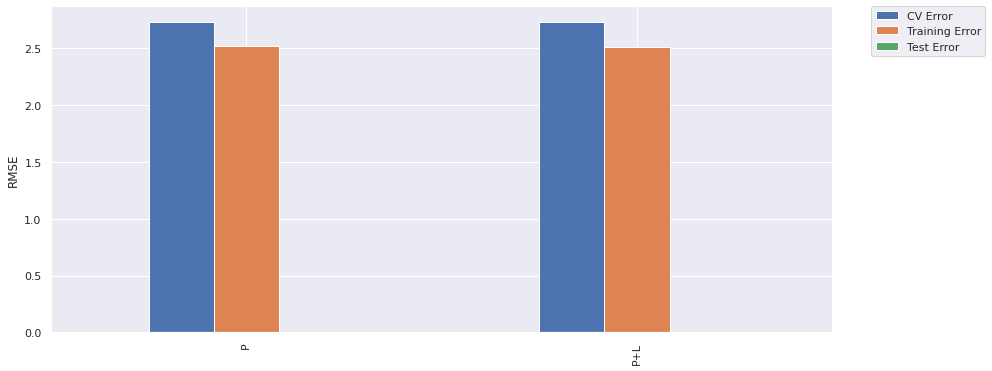

In [327]:
compare_models('P+L', loc_cve, loc_te)

### Model 3

For our third model, lets add important medical and policy information to our model.

In [328]:
p_l_m_features = p_l_features + ['#EligibleforMedicare2018', 'MedicareEnrollment,AgedTot2017', '#FTEHospitalTotal2017',
                                 "TotalM.D.'s,TotNon-FedandFed2017", '#HospParticipatinginNetwork2017',
                                 '#Hospitals', '#ICU_beds','SVIPercentile']

med_cve, med_te = regress(train, p_l_m_features)

print('CV Error (RMSE):', med_cve)
print('Training Error (RMSE):', med_te)

CV Error (RMSE): 2.8563264028407476
Training Error (RMSE): 2.4811218647234066


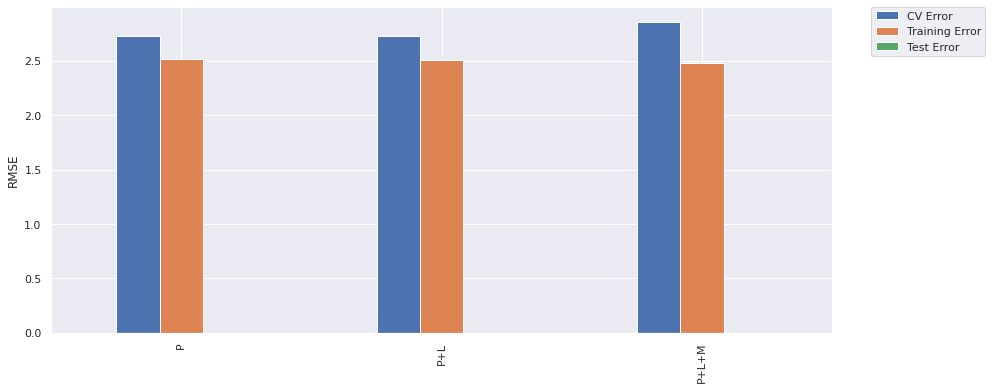

In [329]:
compare_models('P+L+M', med_cve, med_te)

### Model 4

For this model we will just look at the variables we identified in the beginning as being highly correlated with mortality rates.

In [330]:
high_cor_features

['MedianAge2010',
 'DiabetesPercentage',
 'HeartDiseaseMortality',
 'StrokeMortality',
 'Smokers_Percentage',
 'RespMortalityRate2014',
 'dem_to_rep_ratio',
 'agg_cases']

In [331]:
p_l_m_h_features = high_cor_features + p_l_m_features

hc_plus_cve, hc_plus_te = regress(train, p_l_m_h_features)

print('CV Error (RMSE):', hc_plus_cve)
print('Training Error (RMSE):', hc_plus_te)

CV Error (RMSE): 2.8221241955611647
Training Error (RMSE): 2.4180456890869686


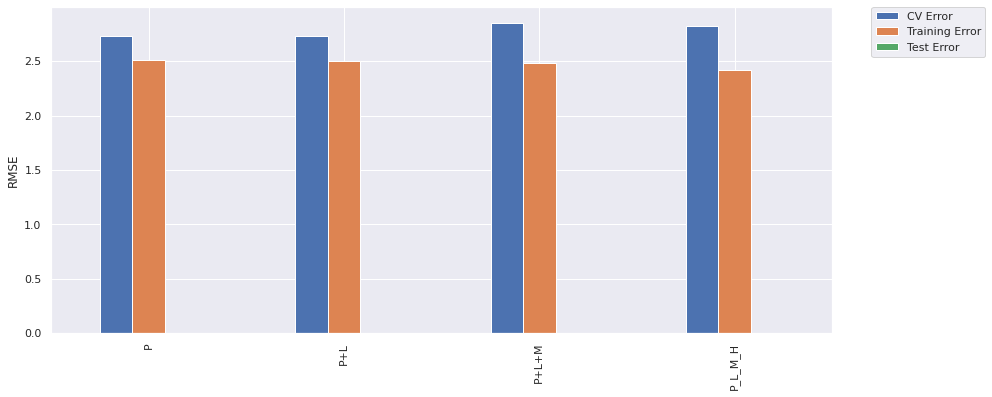

In [332]:
compare_models('P_L_M_H', hc_plus_cve, hc_plus_te)

### Model 5

For this model we will just look at the variables we identified in the beginning as being highly correlated with mortality rates. 

In [333]:
hc_cve, hc_te = regress(train, high_cor_features)

print('CV Error (RMSE):', hc_cve)
print('Training Error (RMSE):', hc_te)

CV Error (RMSE): 2.6232814071935397
Training Error (RMSE): 2.5649931481966854


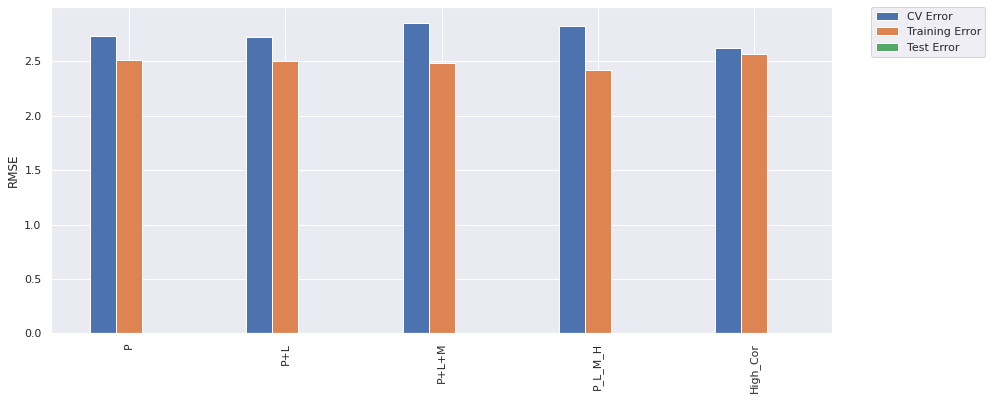

In [334]:
compare_models('High_Cor', hc_cve, hc_te)

As we can see, this model is the best performing of the ones we have tried. 

# **Diagnosing the Model**

Now that we have a best model, lets validate it on our test data. 

In [335]:
X_train = train[high_cor_features]
X_test = test[high_cor_features]

X_test = X_test.iloc[:118]
Y_test = Y_test.iloc[:118]

model = LinearRegression()
model.fit(X_train, Y_train)

Y_hat = model.predict(X_test)

test_error = rmse(Y_test, Y_hat)

print('Test Error (RMSE):', test_error)

Test Error (RMSE): 2.4400481584236937


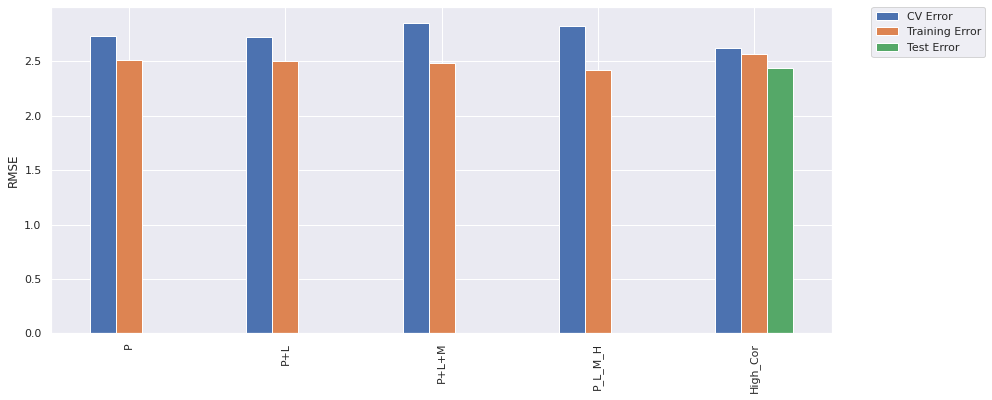

In [336]:
compare_models('High_Cor', cv_score=hc_cve, tr_score=hc_te, te_score=test_error)

Here, we have looked at our validation error just on the model that we have selected. We can see that we succesfully avoided overfitting.

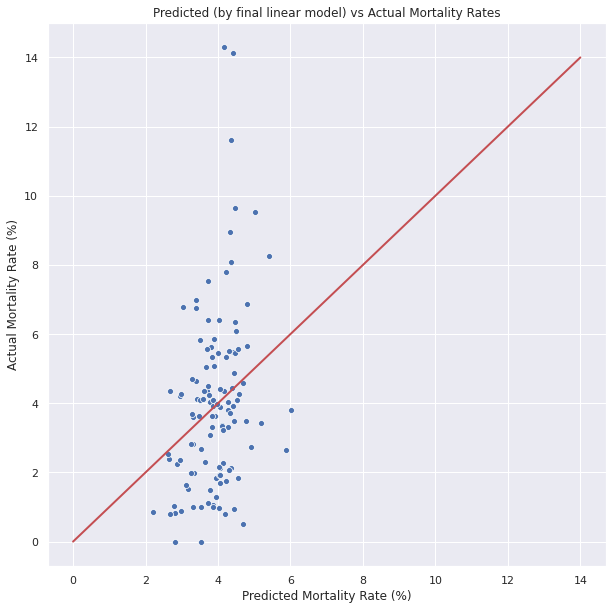

In [342]:
sns.scatterplot(x = Y_hat, y = Y_test)
plt.plot([0, 14], [0, 14], linewidth=2, color="r")
plt.xlabel('Predicted Mortality Rate (%)')
plt.ylabel('Actual Mortality Rate (%)')
plt.title('Predicted (by final linear model) vs Actual Mortality Rates');

Above we have graphed the actual mortality rates versus the predicted mortality rates. While ideally, the plotted points would generally follow the red y = x line, this is not the case. We will consider possible reasonings and responses in the report.

Now lets look at the specific weights for our model to see which are most significant at predicting the Covid mortality rate in a particular county.

In [338]:
coef_data = {'features':high_cor_features, 'weights':model.coef_}

coefficients = pd.DataFrame(coef_data)
coeffs_sorted = coefficients.sort_values(by='weights', ascending=False)
coeffs_sorted

,features,weights
7,agg_cases,0.555753
0,MedianAge2010,0.510758
5,RespMortalityRate2014,0.227343
4,Smokers_Percentage,0.196592
2,HeartDiseaseMortality,0.179939
3,StrokeMortality,0.139079
6,dem_to_rep_ratio,0.050372
1,DiabetesPercentage,-0.236605


Text(0, 0.5, 'Feature')

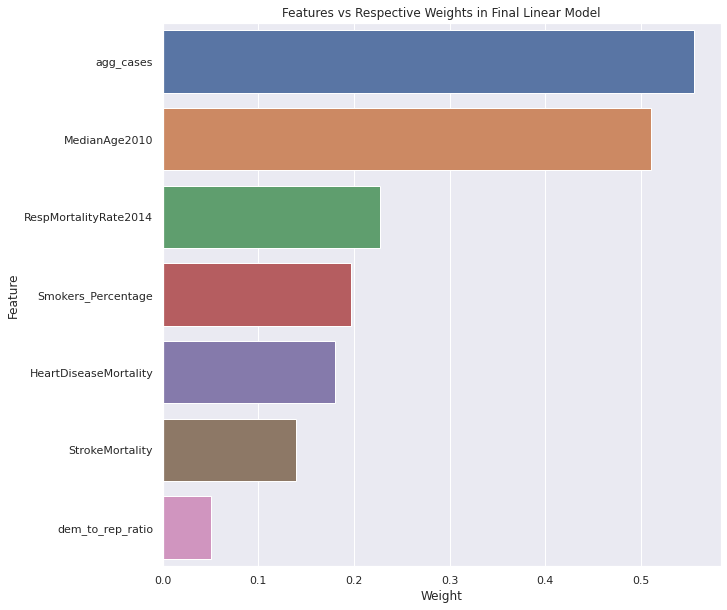

In [339]:
coeffplt = coeffs_sorted[coeffs_sorted['weights'] > .05] 
sns.barplot(x = 'weights', y = 'features', data = coeffplt, orient = 'h')
plt.title('Features vs Respective Weights in Final Linear Model')
sns.set(rc={'figure.figsize':(10, 10)})
plt.xlabel('Weight')
plt.ylabel('Feature')

The top three features (available in ***counties***) at predicting Covid mortality percentage per county are:



1.   *agg_cases*: number of Covid cases per county

2.   *MedianAge2010*: median age in of county in 2010

3. *RespMortalityRate2014*: estimated resperatory  mortality rate of county in 2014

where a one standard unit increase in ***agg_cases***, ***MedianAge2010***, and ***RespMortalityRate2014*** results in a **0.55**, **0.51**, and **0.23** increase in Covid mortality percentage,  respectively.
